# Script for testing Densepose
This script checks the Densepose class and outputs


Pending:
1) Dataloaders pending update to link to Google Bucket


## Imports

In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [ ]:
!pip install torch
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html 
#!pip install git+https://github.com/facebookresearch/detectron2.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html


In [ ]:
!pip install git+https://github.com/facebookresearch/detectron2.git    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2czn92cx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2czn92cx
  Resolved https://github.com/facebookresearch/detectron2.git to commit e020497c85873c2b811ac87dd2e4a34a806e4c2b
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
sys.path.append('./models')

In [ ]:
from models.pose import DenseNet
from densepose import add_densepose_config

from detectron2.structures.instances import Instances
from detectron2.structures.boxes import Boxes

## Temporary dataloader

In [ ]:
# Folder locations
dir_input = '../DeepFashionMultimodal_Men/images/'
dir_desired = '../DeepFashionMultimodal_Men/densepose/'

In [ ]:
#Setting up image parameters
height = 1101
width = 1101 #750

In [ ]:
#Checking through segmentation library
#Checking all listed files
list_input = []
list_desired = []
for root, dirs, files in os.walk(dir_desired):
   for file in files:
      list_desired.append(os.path.join(root, file))
      list_input.append(dir_input + file[:-14] + '.jpg') 

print(len(list_desired))
print(len(list_input))

5437
5437


In [ ]:
class DataLoaderDensePose(torch.utils.data.dataset.Dataset):
    def __init__(self, image_files, pose_files):
        super(DataLoaderDensePose, self).__init__()
        self.img_files = image_files
        self.label_files = pose_files
                
        # Data augmentation and normalization for training
        # Just normalization for validation
        self.transforms = transforms.Compose([
                    transforms.Resize((height, width)),
                    transforms.ToTensor(),
                ])
    
    def __getitem__(self, index):
            img_path = self.img_files[index]
            label_path = self.label_files[index]

            image = Image.open(img_path).convert('RGB')
            label = Image.open(label_path).convert('RGB')

            # Make the image square and downsample it after
            image = expand2square(image, (0, 0, 0))
            label = expand2square(label, (0, 0, 0))
            
            # Apply Transforms 
            image = self.transforms(image)
            label = self.transforms(label)

            return image, label, label_path

    def __len__(self):
        return len(self.img_files)

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


In [ ]:
FashionDataset={
    'img': DataLoaderDensePose(list_input, list_desired)
}

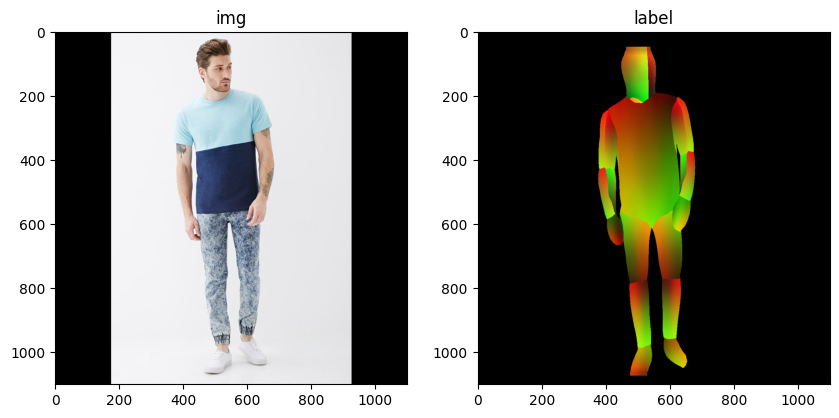

In [ ]:
# Unit test for Sample display
img, lab, path = FashionDataset['img'][0]
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(img.permute((1,2,0)))
axs[0].set_title('img')
axs[1].imshow(lab.permute((1,2,0)))
axs[1].set_title('label') 

plt.show()

## Loading model

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#thisdir = os.path.dirname(__file__)
def set_instances(box, bs):
    box = Boxes(box)
    instances = [{'pred_classes': torch.tensor([0], device=box.device), 'pred_boxes': box} for _ in range(bs)]
    #instances = [Instances(image_size=(256, 256), **x) for x in instances]
    instances = [Instances(image_size=(height, width), **x) for x in instances]
    return instances

In [ ]:
model_pose = DenseNet().to(device)

## Evaluation

In [ ]:
def set_instances(box, bs):
    box = Boxes(box)
    instances = [{'pred_classes': torch.tensor([0], device=box.device), 'pred_boxes': box} for _ in range(bs)]
    instances = [Instances(image_size=(height, width), **x) for x in instances]
    return instances

In [ ]:
im, lab, lab_path = FashionDataset['img'][20]
bs = 1#img.size(0)
box = torch.tensor([[0, 0, height, width]], device=img.device)
instances = set_instances(box, bs)

In [ ]:
pose = model_pose.forward(im.unsqueeze(0).to(device), instances)
pose = pose.squeeze(0).permute((1,2,0)).detach().cpu()
res = np.zeros(pose.shape)
for i in range(pose.shape[2]):
  res[:,:,i] = pose[:, :, i] * (i+1)

res = np.sum(res,axis=2)
print(res.shape)

(112, 112)


Text(0.5, 1.0, 'densepose output')

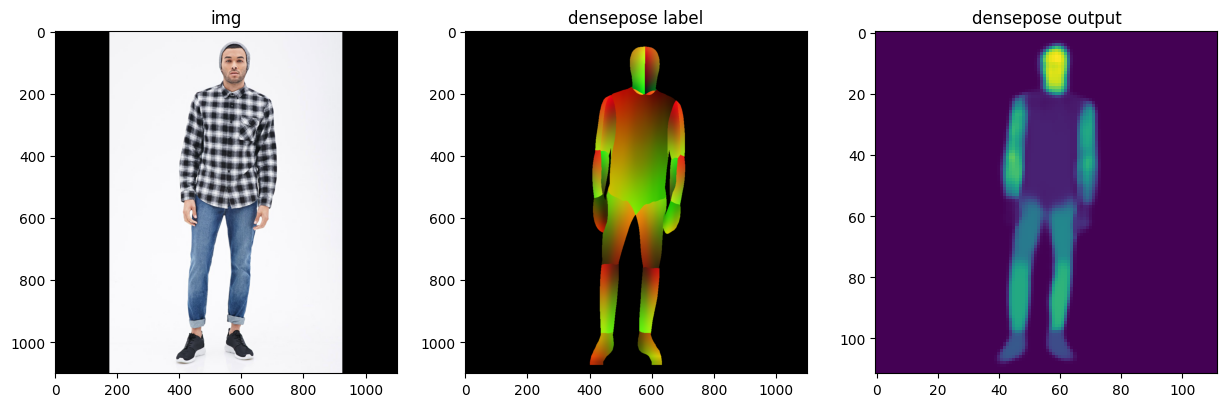

In [ ]:
#Sample display
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(im.squeeze(0).permute((1,2,0)))
axs[0].set_title('img')
axs[1].imshow(lab.permute((1,2,0)))
axs[1].set_title('densepose label')
axs[2].imshow(res)
axs[2].set_title('densepose output')
